# COM6509 Assignment 2

## 1. Parameters setting
As required, my UCard number 200206297 will be set as the random seed and some parameter will also be shown in this part.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from functools import reduce
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import itertools
import seaborn as sns
import datetime, time
plt.style.use("ggplot")

In [2]:
torch.manual_seed(200206297)
inputSize = 784
numClasses = 10
numEpochs = 20
batchSize = 32
learningRate = 0.001

## 2. Supervised learning on Fashion-MNIST

### 2.1 Data loading and inspectin

#### a. Load data 
PyTorch API for Fashion_MNIST will be use to load the training and test data of Fashion_MNIST. Ten classes of the dataset will be set. In this part, the size of training and test set will be printed.

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(0.5, 0.5)])
trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=False, num_workers=2)
#Load the test data
testset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, 
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
print('Training set size:', len(trainset))
print('Test set size:',len(testset))

Training set size: 60000
Test set size: 10000


#### b. Display images
First, the imshow function will be defined to rearrange dimensions to numpy format for disply. Then, trainset.targets will be used to get eight images in each class and display them.

In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #rearrange dimensions to numpy format for disply
    plt.show()

D:\PROGRAM\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  after removing the cwd from sys.path.


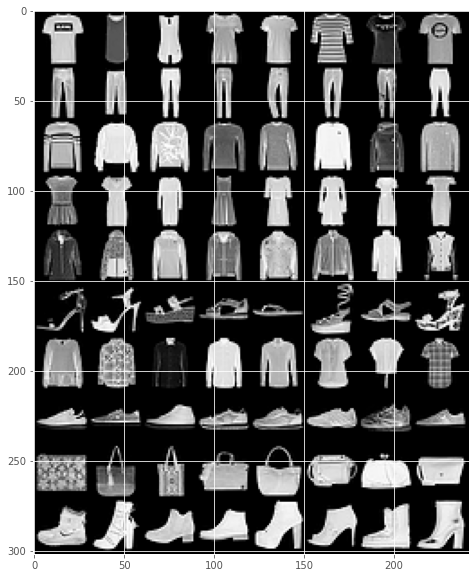

In [5]:
plt.figure(figsize=(10,10))
indexlist = [] 
for i in range(10):
    indices =(trainset.targets == i).nonzero()[:8]
    indexlist += indices.tolist()
plot_image = trainset.data[indexlist]
plt.imshow(np.transpose(torchvision.utils.make_grid(plot_image),(1,2,0)))

### 2.2 Evaluation metrics
#### M1) Traininig accuracy
The training accuracy will be
$$accuracy = \frac{total\ correct train}{total}$$

#### M2) Test accuracy
The test accuracy will be
$$ accuracy = \frac{total\ correct test}{total}$$ 

#### M3) Training time
The package datetime will be used to calculate.

#### M4) Number of learnable parameters
The code 

* total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())

will be used.

### 2.3 Logistic regression

A function Run will be defined and the optimizer will be a parameter of the function. L1 regularisation will be contained in Run function with a coefficient is_L1 to achieve L1 regularisation. The logistic regression without regularisation and the regression wuth L2 regularisation can be achieve by change the optimizer.

In [6]:
class LogisticRegression(nn.Module):
    def __init__(self, inputSize, numClasses):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(inputSize, numClasses)
    def forward(self, x):
        out = self.linear(x)
        x = torch.sigmoid(x)
        return out

In [7]:
LR = LogisticRegression(inputSize, numClasses)

def Run(numEpochs, model, optimizer, is_L1):
    criterion = nn.CrossEntropyLoss()  
    
    start = datetime.datetime.now()
    # Training the Model
    for epoch in range(numEpochs):
        for i, (images, labels) in enumerate(trainloader):
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
            
            penty = torch.sum(torch.abs(next(model.parameters()))) #L1
            # Forward + Backward + Optimize
            optimizer_none.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels) + 0.001*penty*is_L1
            loss.backward()
            optimizer_none.step()

#            if (i+1) % 100 == 0:
#                print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
#                       % (epoch+1, numEpochs, i+1, len(trainset)//batchSize, loss.data.item()))
    end = datetime.datetime.now()
    total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
    train_time = end-start
    train_time = train_time.total_seconds()
    
#Test the Model on trainset
    correct_train = 0
    total_train = 0
    trainloader_test = torch.utils.data.DataLoader(trainset, batch_size=60000,
                                          shuffle=False, num_workers=2)
    for images, labels in trainloader_test:
        images = Variable(images.view(-1, 28*28))
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum()
        accuracy_trainset = correct_train / total_train
    print('Accuracy of the model on the 60000 train images: %d %%' % (100 * accuracy_trainset)) 

    # Test the Model
    correct = 0
    total = 0
    for images, labels in testloader:
        images = Variable(images.view(-1, 28*28))
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    cm = confusion_matrix(labels,predicted)
    plt.figure(figsize=(16, 16))
    sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, fmt = "g")
    accuracy_testset = correct / total
    print('Accuracy of the model on the 10000 test images: %d %%' % (100 * accuracy_testset))
    print('Training time :', train_time)
    print('The number of total parameters :', total_params)
    
    return(accuracy_trainset, accuracy_testset, train_time, total_params)

#### a) Logistic regression without regularisation

Accuracy of the model on the 60000 train images: 84 %
Accuracy of the model on the 10000 test images: 82 %
Training time : 133.977446
The number of total parameters : 7850


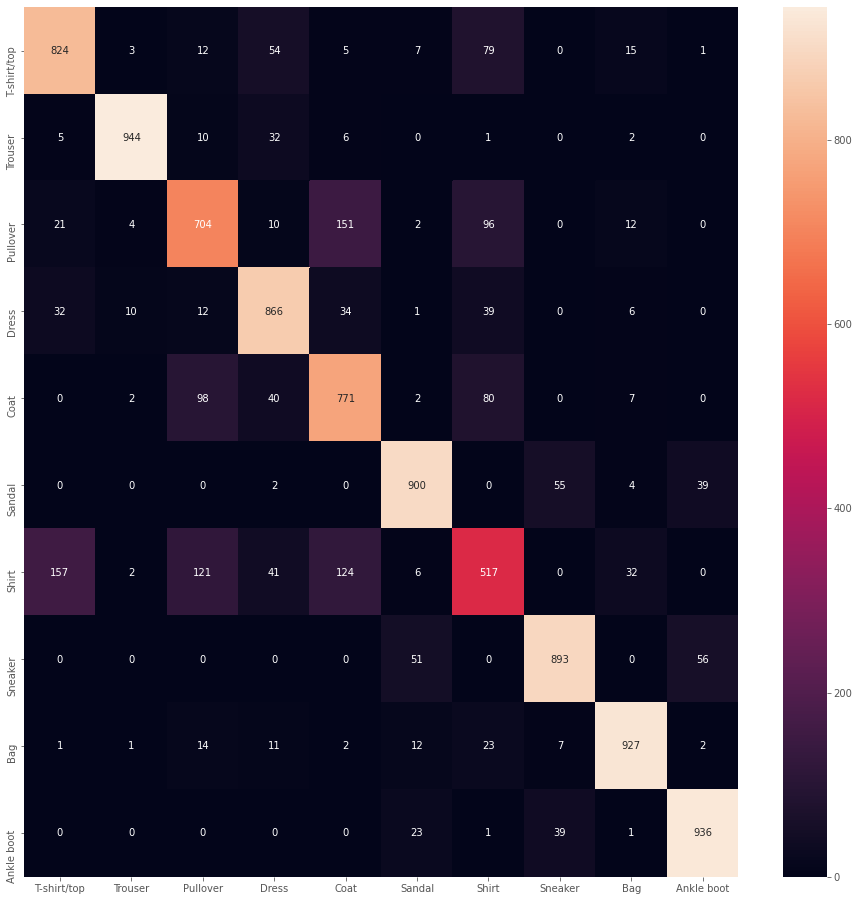

In [8]:
optimizer_none = torch.optim.SGD(LR.parameters(), lr=learningRate)
(accuracy_trainset_none, accuracy_testset_none, train_time_none, total_params_none) = Run(numEpochs, LR, optimizer_none, 0)

#### b) Logistic regression with L1 regularsation
Here, the coefficient is_L1 should equal to 1.

Accuracy of the model on the 60000 train images: 84 %
Accuracy of the model on the 10000 test images: 83 %
Training time : 130.691568
The number of total parameters : 7850


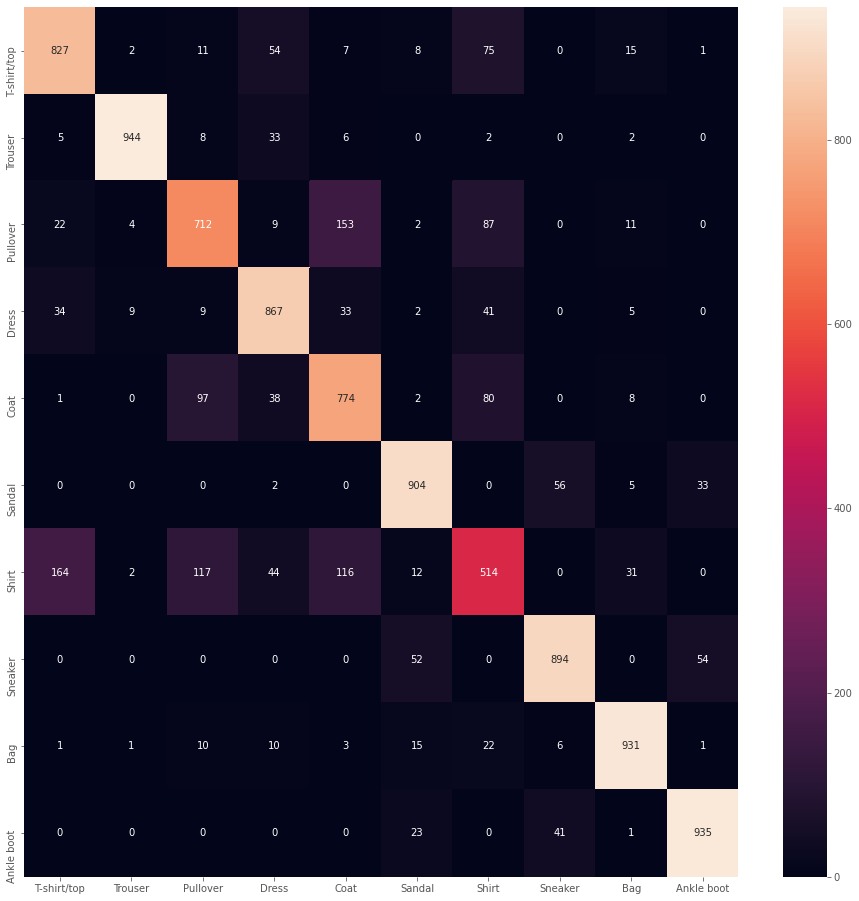

In [9]:
(accuracy_trainset_L1, accuracy_testset_L1, train_time_L1, total_params_L1) = Run(numEpochs, LR, optimizer_none, 1) #with L1 regularisation

#### c) Logistic regression with L2 regularsation

Accuracy of the model on the 60000 train images: 85 %
Accuracy of the model on the 10000 test images: 83 %
Training time : 149.730063
The number of total parameters : 7850


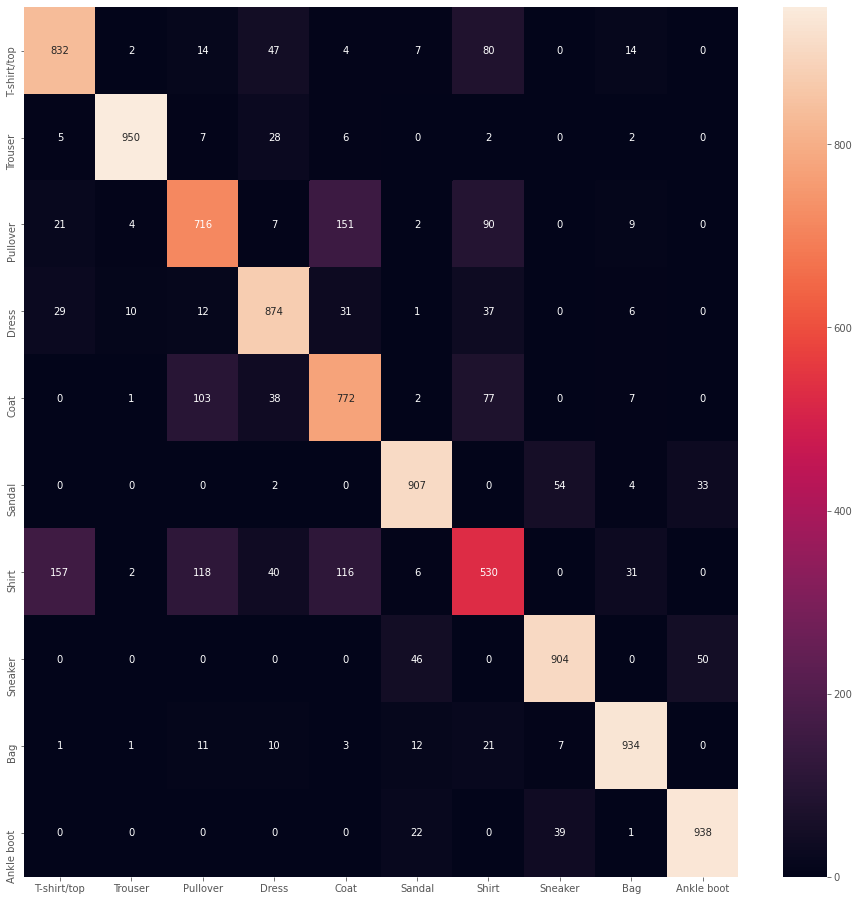

In [10]:
optimizer_L2 = torch.optim.SGD(LR.parameters(), lr=learningRate,weight_decay = 0.001)
(accuracy_trainset_L2, accuracy_testset_L2, train_time_L2, total_params_L2) = Run(numEpochs, LR, optimizer_L2, 0) # with L2 regularisation

### 2.4 Convolutional Neural Networks
The function ruu_CNN will be defined to use models training and test data. Also, M1 to M4 and confusion matrix will be reported. Then, three CNNs will be constructed.

In [11]:
def run_CNN(model):
    start = datetime.datetime.now()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(numEpochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.data.cuda())
            loss = criterion(outputs, labels.data.cuda())
            loss.backward()
            optimizer.step()

            # print statistics
#            running_loss += loss.data.cpu().item()
#            if (i+1) % 100 == 0:    # print every 2000 mini-batches
#                print('[%d, %5d] loss: %.5f' % (epoch + 1, i + 1, running_loss / 100))
#               running_loss = 0.0
    end = datetime.datetime.now()
    
    train_time = end - start
    train_time = train_time.total_seconds()
    total_params = sum(reduce( lambda a, b: a*b, x.size()) for x in model.parameters())
    
    #Test on trainset 
    trainloader_test = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=False, num_workers=2)
    dataiter = iter(trainloader_test)
    images, labels = dataiter.next()
    model = model.cpu()
    correct = 0
    total = 0
    with torch.no_grad():  #testing phase, no need to compute the gradients to save time
        for data in trainloader_test:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy_trainset = correct / total   
    
    #Test on testset
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    correct = 0
    total = 0
    with torch.no_grad():  #testing phase, no need to compute the gradients to save time
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy_testset = correct / total
    cm = confusion_matrix(labels,predicted)
    plt.figure(figsize=(16, 16))
    sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, fmt = "g")
    
    print('Accuracy of the network on the 60000 train images: %d %%' % (100 * accuracy_trainset)) 
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * accuracy_testset)) 
    print('Training time :', train_time)
    print('The number of total parameters :', total_params)
    
    return(accuracy_trainset, accuracy_testset, train_time, total_params)

#### a) CNN with two Conv layers and two FC layers

In [12]:
class FashionCNN_conv2_fc2(nn.Module):
    
    def __init__(self):
        super(FashionCNN_conv2_fc2, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)

        return out


Accuracy of the network on the 60000 train images: 94 %
Accuracy of the network on the 10000 test images: 90 %
Training time : 156.708935
The number of total parameters : 1408018


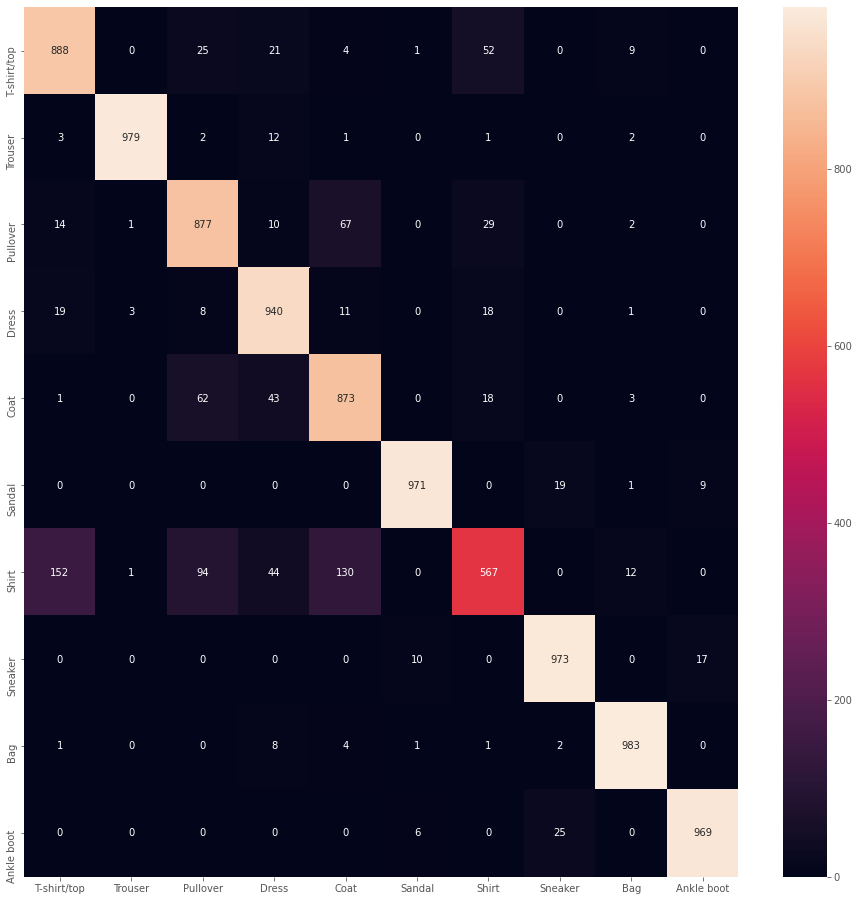

In [13]:
(accuracy_trainset_22, accuracy_testset_22, train_time_22, total_params_22) = run_CNN(FashionCNN_conv2_fc2().cuda())

#### b) CNN with two Conv layers and five FC layers

In [14]:
class FashionCNN_conv2_fc5(nn.Module):
    
    def __init__(self):
        super(FashionCNN_conv2_fc5, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=1200)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=1200, out_features=600)
        self.fc3 = nn.Linear(in_features=600, out_features=300)
        self.fc4 = nn.Linear(in_features=300, out_features=100)
        self.fc5 = nn.Linear(in_features=100, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        return out

Accuracy of the network on the 60000 train images: 95 %
Accuracy of the network on the 10000 test images: 90 %
Training time : 184.293992
The number of total parameters : 3717018


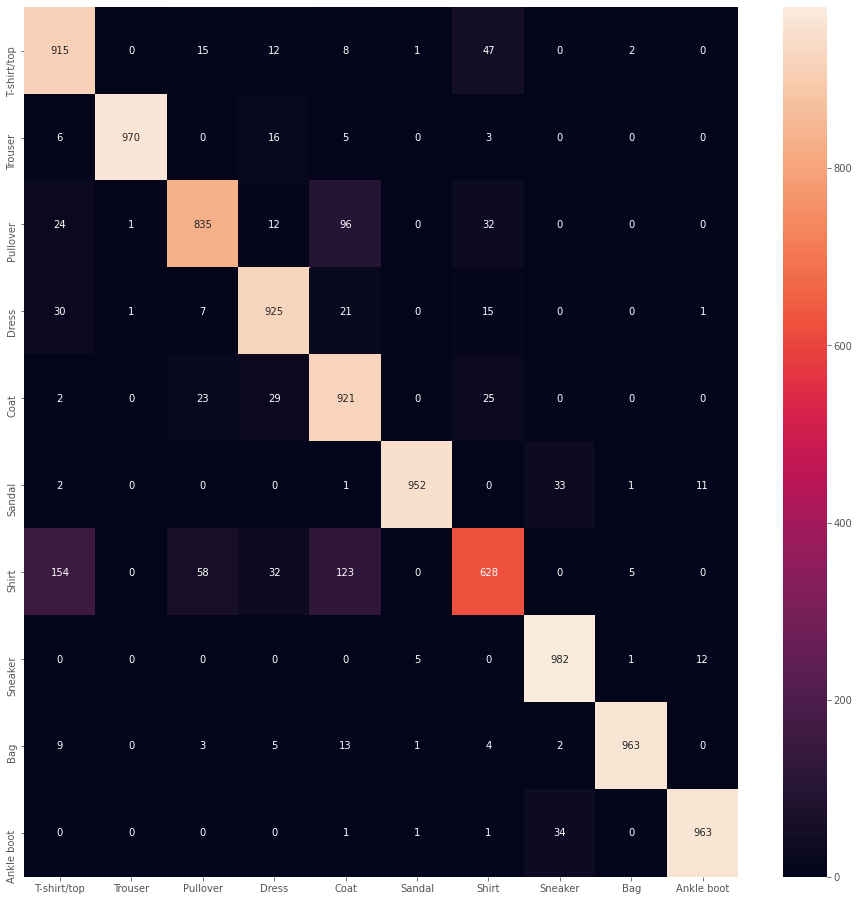

In [15]:
(accuracy_trainset_25, accuracy_testset_25, train_time_25, total_params_25) = run_CNN(FashionCNN_conv2_fc5().cuda())

#### c) CNN with five Conv layers and two FC layers

In [16]:
class FashionCNN_conv5_fc2(nn.Module):
    
    def __init__(self):
        super(FashionCNN_conv5_fc2, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size =3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.layer4 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(in_features=512*14*14, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)

        return out

Accuracy of the network on the 60000 train images: 99 %
Accuracy of the network on the 10000 test images: 92 %
Training time : 914.867276
The number of total parameters : 61787794


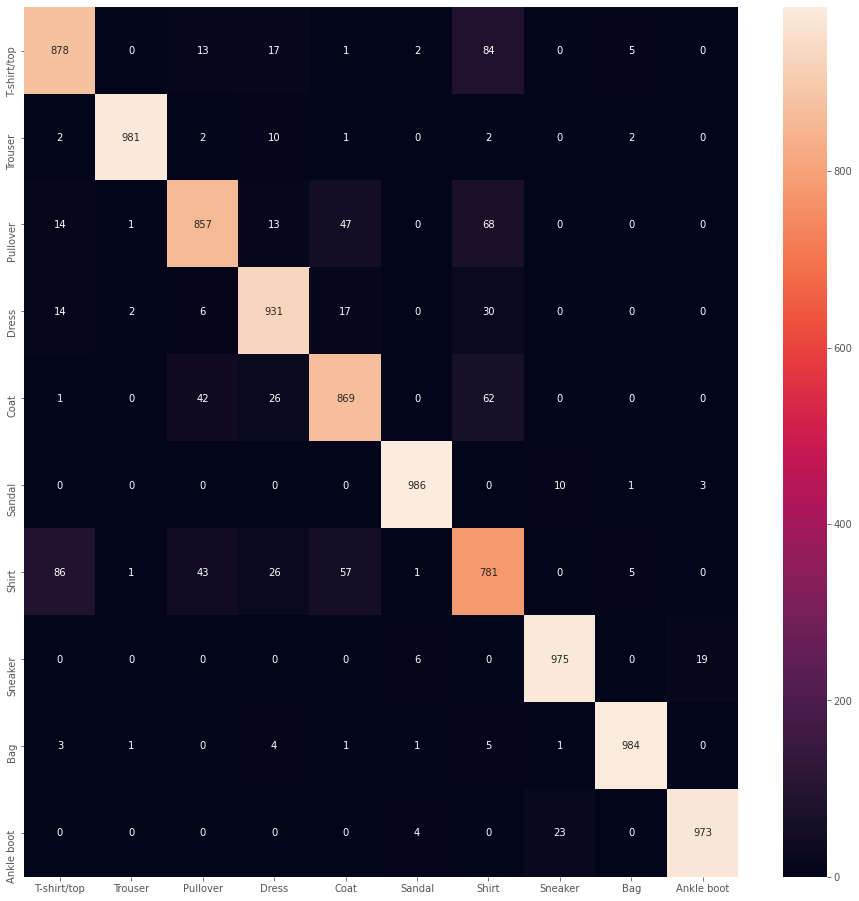

In [17]:
(accuracy_trainset_52, accuracy_testset_52, train_time_52, total_params_52) = run_CNN(FashionCNN_conv5_fc2().cuda())

### 2.4 Performance comparison

#### a) Summary of metrics

<function matplotlib.pyplot.show(close=None, block=None)>

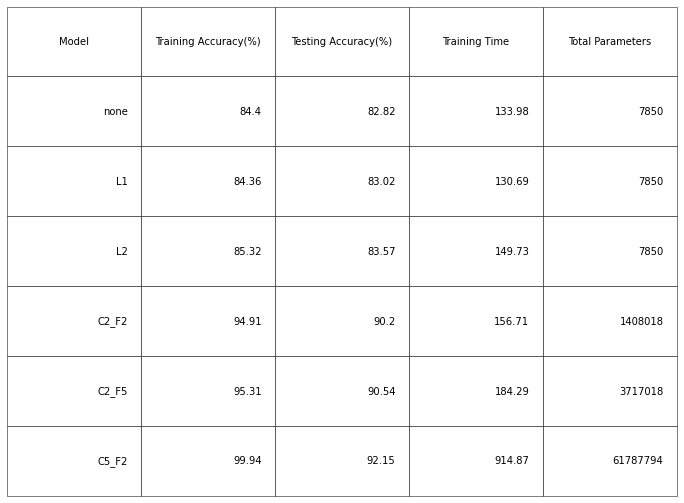

In [18]:
import matplotlib.pyplot as plt

import pandas as pd
data = {
"Model" : ['none', 'L1', 'L2', 'C2_F2', 'C2_F5', 'C5_F2'],
    
'Training Accuracy(%)': [str(round(accuracy_trainset_none.numpy()*100,2)), str(round(accuracy_trainset_L1.numpy()*100,2)), str(round(accuracy_trainset_L2.numpy()*100,2)),
                        round(accuracy_trainset_22*100, 2), round(accuracy_trainset_25*100, 2), round(accuracy_trainset_52*100,2)],

'Testing Accuracy(%)': [str(round(accuracy_testset_none.numpy()*100,2)), str(round(accuracy_testset_L1.numpy()*100,2)), str(round(accuracy_testset_L2.numpy()*100,2)),
                        round(accuracy_testset_22*100, 2), round(accuracy_testset_25*100, 2), round(accuracy_testset_52*100,2)],
    
    
"Training Time" : [round(train_time_none,2), round(train_time_L1, 2), round(train_time_L2, 2),
             round(train_time_22,2), round(train_time_25,2), round(train_time_52,2)],
    
"Total Parameters" : [total_params_none, total_params_L1, total_params_L2,
               total_params_22, total_params_25, total_params_52]


}

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=( 12, 9))

ax.axis( 'off')

ax.axis( 'tight')

ax.table(cellText=df.values, colLabels=df.columns, bbox=[ 0, 0, 1, 1])

plt.show

Text(0, 0.5, 'Number of Parameters')

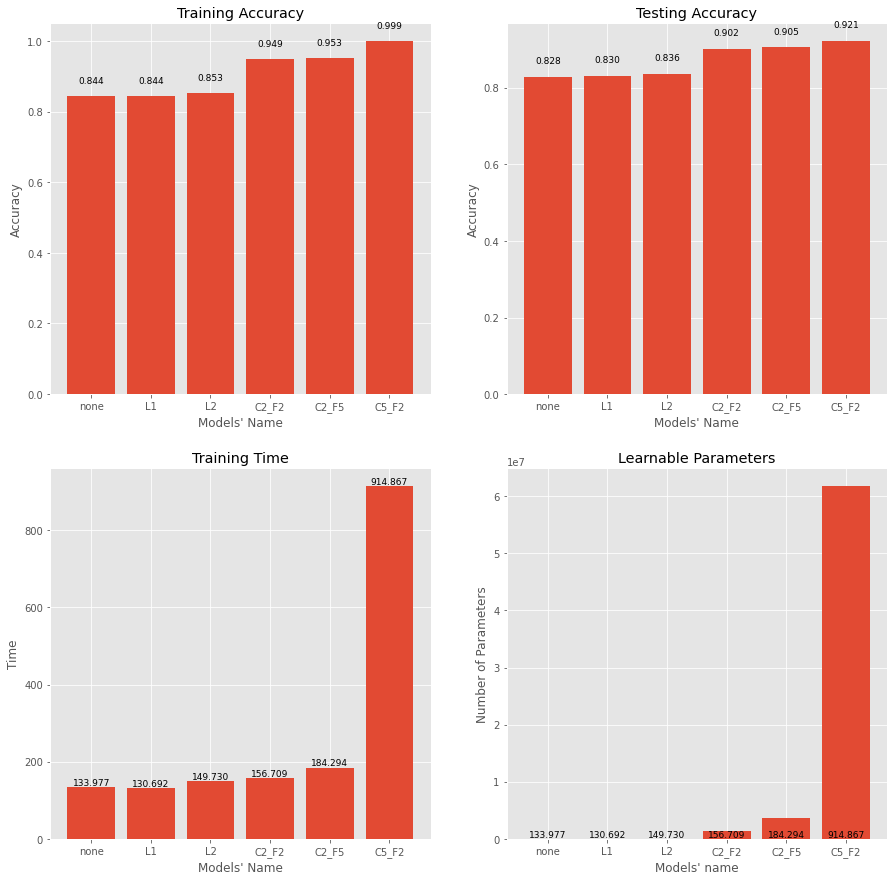

In [19]:
x_accuracy_train = ('none', 'L1', 'L2', 'C2_F2', 'C2_F5', 'C5_F2')
y_accuracy_train = (accuracy_trainset_none, accuracy_trainset_L1, accuracy_trainset_L2 ,
                        accuracy_trainset_22, accuracy_trainset_25, accuracy_trainset_52)

x_accuracy_test = ('none', 'L1', 'L2', 'C2_F2', 'C2_F5', 'C5_F2')
y_accuracy_test = (accuracy_testset_none, accuracy_testset_L1, accuracy_testset_L2,
                      accuracy_testset_22, accuracy_testset_25, accuracy_testset_52)

x_time = ('none', 'L1', 'L2', 'C2_F2', 'C2_F5', 'C5_F2')
y_time = (train_time_none, train_time_L1, train_time_L2,
             train_time_22, train_time_25, train_time_52)

x_params = ('none', 'L1', 'L2', 'C2_F2', 'C2_F5', 'C5_F2')
y_params = (total_params_none, total_params_L1, total_params_L2,
               total_params_22, total_params_25, total_params_52)

plt.figure(figsize=(15,15))

###Training accuracy
plt.subplot(2,2,1)
plt.bar(x_accuracy_train, y_accuracy_train, align='center')

for a,b in zip(x_accuracy_train, y_accuracy_train): 
    plt.text(a, b+0.03, '%.3f' % b, ha='center', va= 'bottom',fontsize=9)

plt.title('Training Accuracy')
plt.xlabel('Models\' Name')
plt.ylabel('Accuracy')

###Testing accuracy
plt.subplot(2,2,2)
plt.bar(x_accuracy_test, y_accuracy_test, align='center')

for a,b in zip(x_accuracy_test, y_accuracy_test): 
    plt.text(a, b+0.03, '%.3f' % b, ha='center', va= 'bottom',fontsize=9)

plt.title('Testing Accuracy')
plt.xlabel('Models\' Name')
plt.ylabel('Accuracy')

### Training time
plt.subplot(2,2,3)
plt.bar(x_time, y_time, align='center')

for a,b in zip(x_time, y_time): 
    plt.text(a, b+0.03, '%.3f' % b, ha='center', va= 'bottom',fontsize=9)

plt.title('Training Time')
plt.xlabel('Models\' Name')
plt.ylabel('Time')

###Total parameters
plt.subplot(2,2,4)
plt.bar(x_params, y_params, align='center')

for a,b in zip(x_time, y_time): 
    plt.text(a, b+0.03, '%.3f' % b, ha='center', va= 'bottom',fontsize=9)

plt.title('Learnable Parameters')
plt.xlabel('Models\' name')
plt.ylabel('Number of Parameters')

#### b) Observations
##### 1) Model complexity
The figure below showed the training time and the number of parameters is positively correlated which means when the model complexity increased, training the model will need more time. Meanwhile, in these six models, complex models can improve accuracy.
##### 2) Results on testset and trainset
It is obvious that the six models have better performance on trainset than testset. It might because those models are trained on the trainset so that models can fit trainset better. When those models be applied to testset, because the testset and trainset are from the same dataset FashionMNIST, the performance on testset would not very bad than trainset.

Text(0, 0.5, 'Parameters')

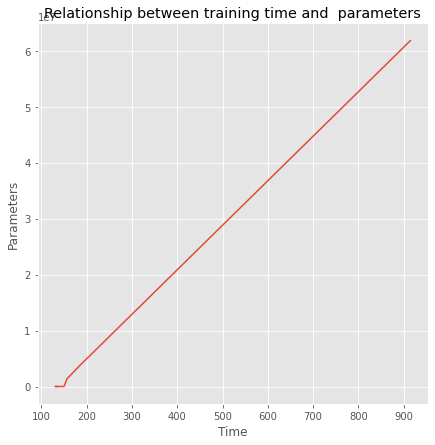

In [20]:
relation_time = (train_time_none, train_time_L1, train_time_L2,
             train_time_22, train_time_25, train_time_52)
relation_params = (total_params_none, total_params_L1, total_params_L2,
               total_params_22, total_params_25, total_params_52)

plt.figure(figsize=(7,7))
plt.plot(relation_time, relation_params)
plt.title('Relationship between training time and  parameters')
plt.xlabel('Time')
plt.ylabel('Parameters')

## 3 Unspervised learning on Fashion_MNIST

'T-shirt/top' and 'Trouser' are chosen in this part.

In [21]:
first = 1
second = 7
choose_index = [first, second]
pca_classes = [classes[choose_index[0]],classes[choose_index[1]]]
indexlist_1 = []
for i in choose_index:
    indices_1 =(trainset.targets == i).nonzero()
    indexlist_1 += indices_1.tolist()
pca_image = trainset.data[indexlist_1]

### 3.1 PCA and k_means

#### a) Apply PCA and Visualise Eigenvectors

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = np.array(pca_image[:][0][0].numpy()).reshape(1, 28*28)
for i in range(1, len(pca_image[:])):
    X = np.append(X,np.array(pca_image[:][i][0].numpy()).reshape(1, 28*28),axis = 0)
X_ss = StandardScaler().fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit(X_ss)
X_norm_r = X_pca.transform(X_ss)
cov_matrix = np.dot(X_ss.T, X_ss) / len(X_ss)

#for eigenvector in pca.components_[:24]:
#       print(eigenvector)

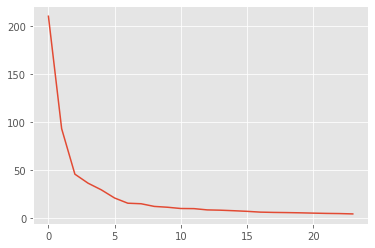

In [23]:
plt.plot(pca.explained_variance_[:24])

#### b) Reconstruct Images

In [24]:
def reconstruction(X_norm_r, n, trans):
    vectors = [trans.components_[n] * X_norm_r[n] for n in range(0, n)]
    ret = trans.inverse_transform(X_norm_r)
    ret[ret < 0] = 0
    ret[ret > 1] = 1
    return ret

D:\PROGRAM\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


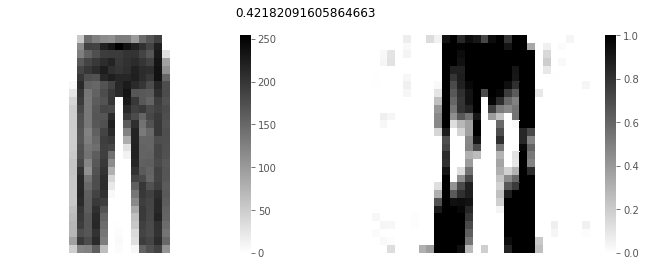

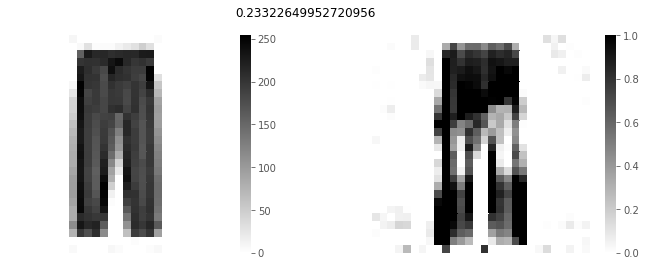

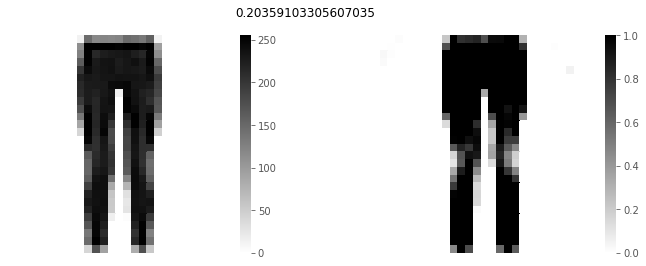

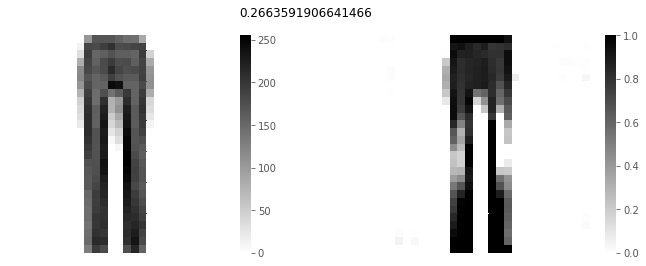

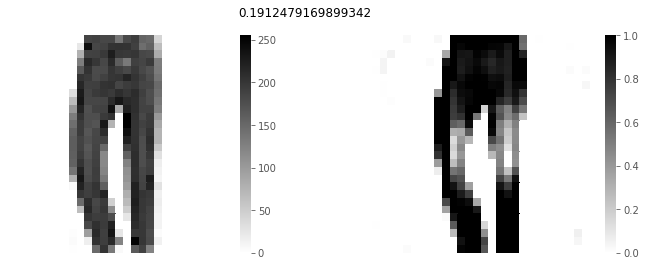

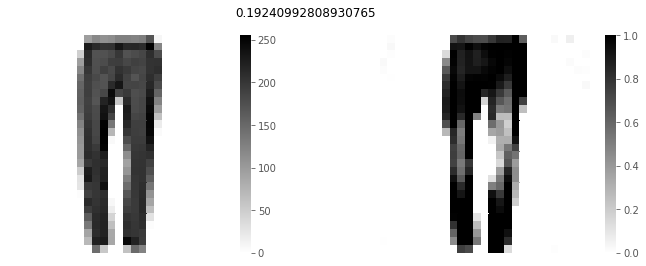

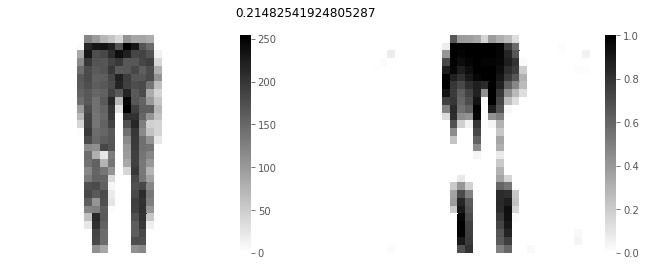

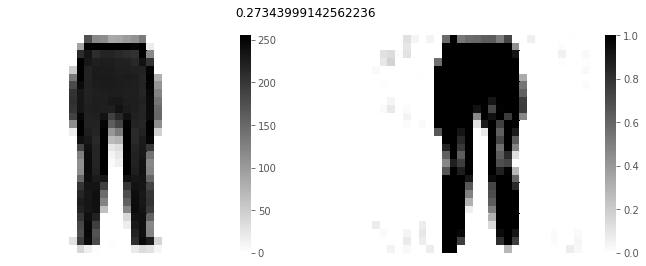

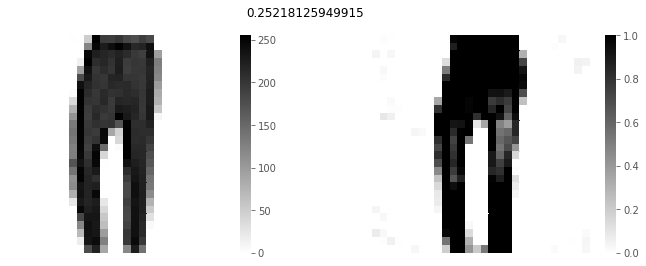

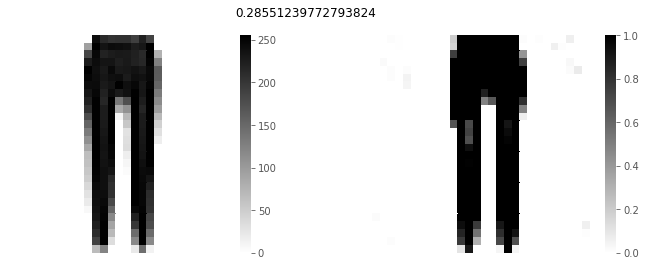

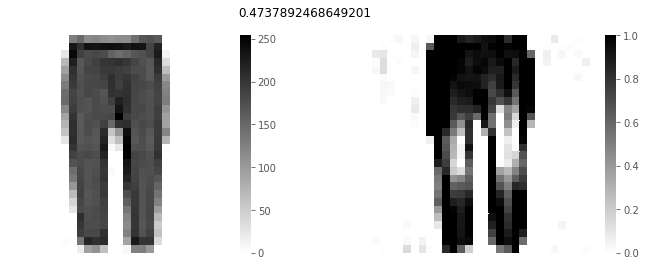

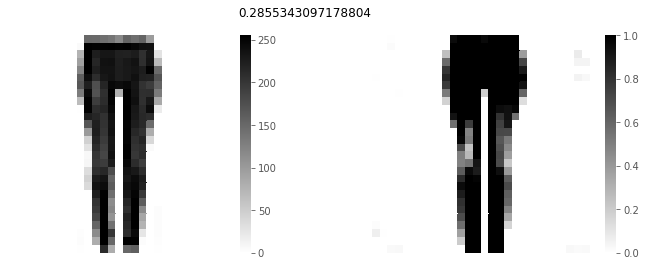

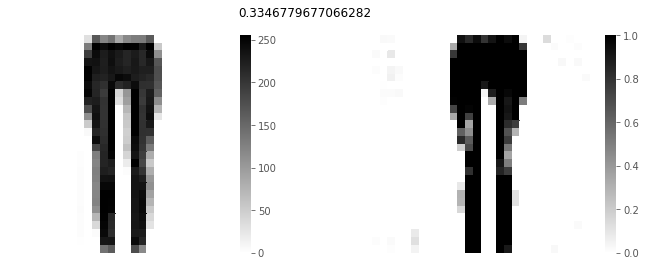

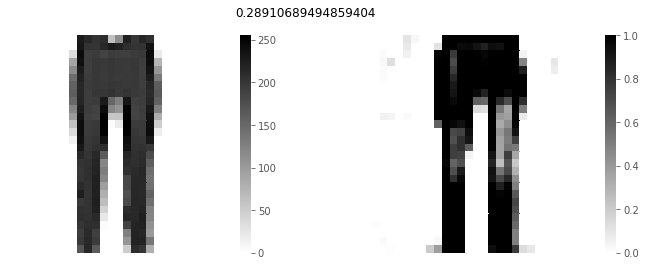

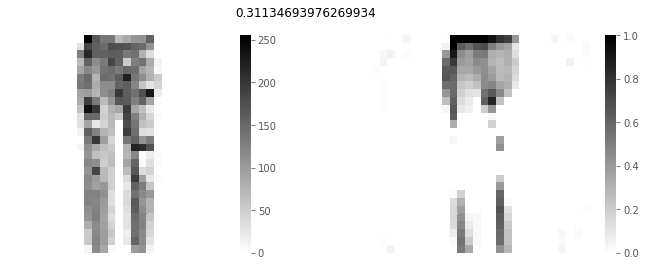

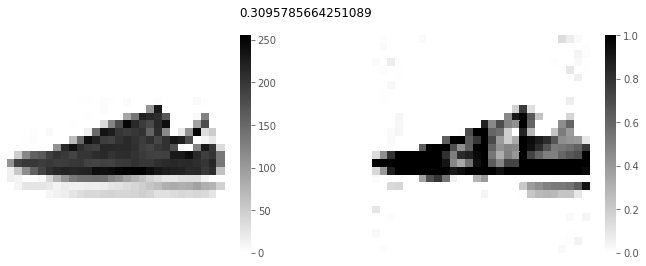

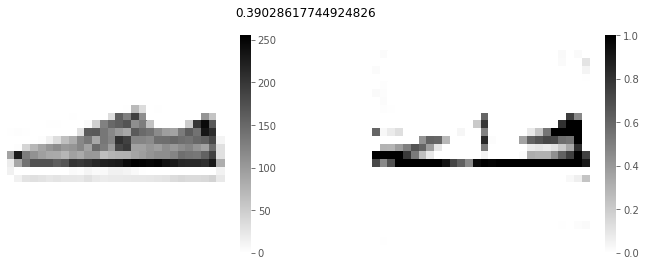

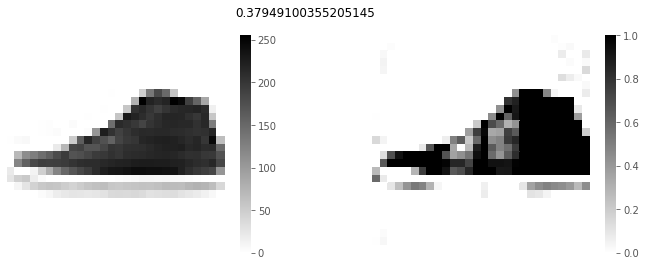

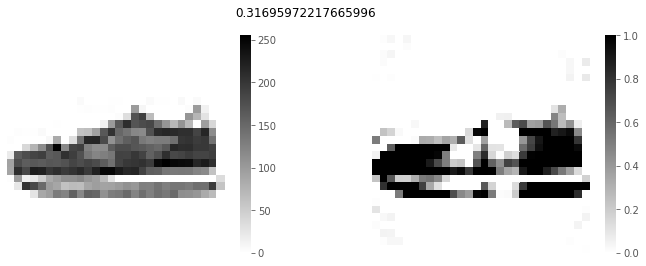

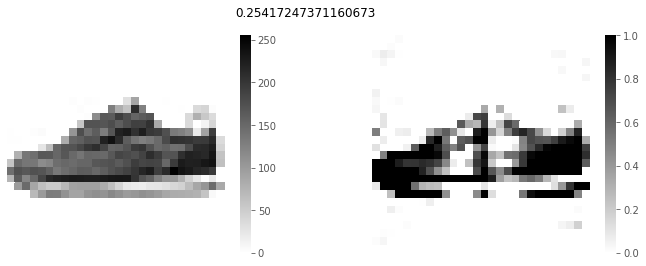

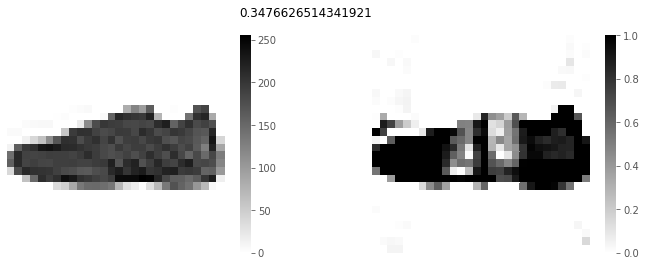

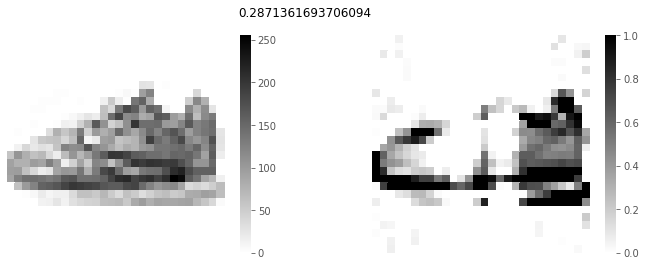

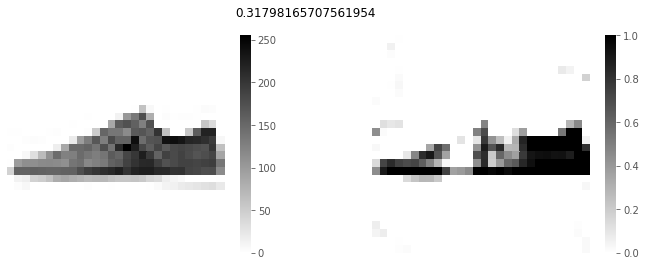

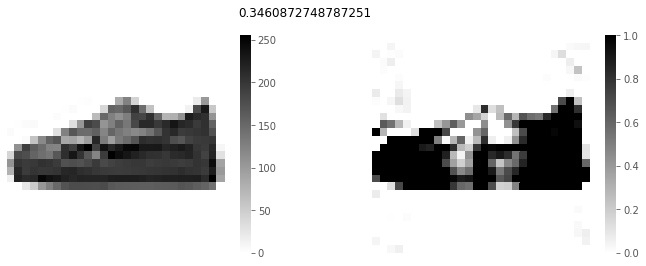

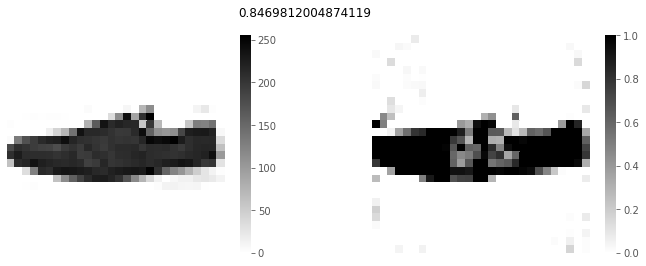

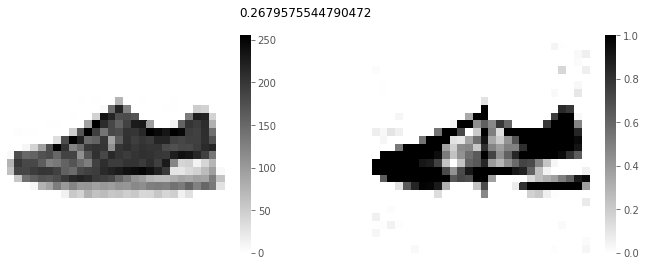

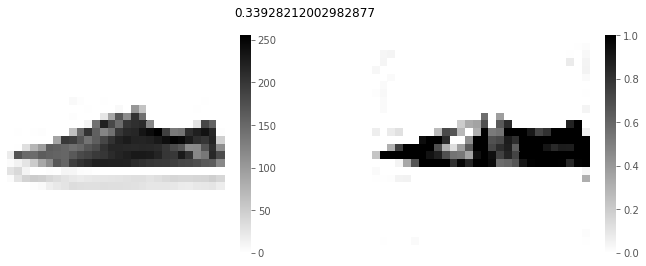

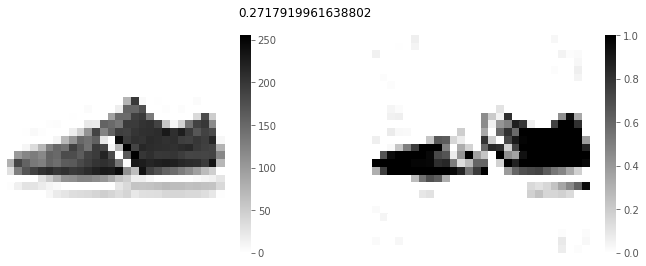

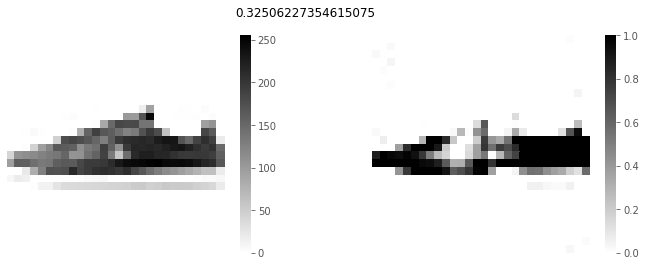

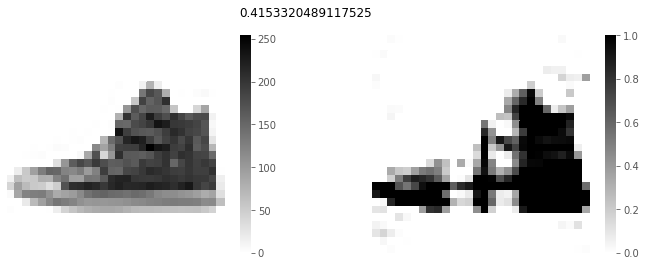

In [25]:
from sklearn.metrics import mean_squared_error
plot_arange = np.append(np.arange(0,15),np.arange(6000,6015))
MSEs = []
for i in plot_arange:
    fig, axarr = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle(mean_squared_error(X_ss[i,:], reconstruction(X_norm_r[i,:],24,pca)))
    sns.heatmap(X[i, :].reshape(28, 28), cmap='gray_r',
                ax=axarr[0])
    sns.heatmap(reconstruction(X_norm_r[i, :], 24, pca).reshape(28, 28), cmap='gray_r',
                ax=axarr[1])
    mean_squared_error(X[i,:], reconstruction(X_norm_r[i,:],24,pca))
    MSEs.append(mean_squared_error(X_ss[i,:], reconstruction(X_norm_r[i,:],24,pca)))
    axarr[0].set_aspect('equal')
    axarr[0].axis('off')
    axarr[1].set_aspect('equal')
    axarr[1].axis('off')

Text(0, 0.5, 'MSE')

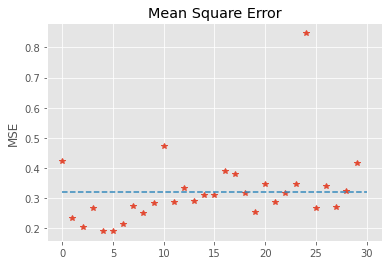

In [26]:
average_MSEs = np.mean(MSEs)
plt.plot(MSEs, "*")
plt.title("Mean Square Error")
x = np.linspace(0, 30 )
y = x * 0 + average_MSEs
plt.plot(x,y, "--")
plt.ylabel("MSE")

#### c) PCA representations

In [27]:
pca_1 = PCA(n_components=2)
X_pca_1 = pca_1.fit(X)
X_norm_r_1 = X_pca_1.transform(X)

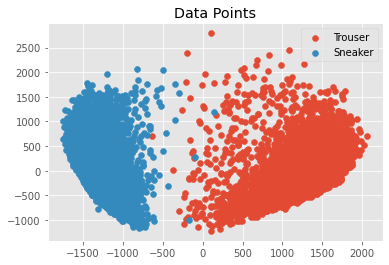

In [28]:
plt.title('Data Points')
A = plt.scatter(X_norm_r_1[0:6000][:,0], X_norm_r_1[0:6000][:,1], cmap=plt.cm.get_cmap('Spectral', 10))
B = plt.scatter(X_norm_r_1[6000:][:,0], X_norm_r_1[6000:][:,1],cmap=plt.cm.get_cmap('Spectral', 10))
plt.legend((A, B),(classes[first], classes[second]))

#### d) K-means

In [29]:
from sklearn.cluster import KMeans
kmeans =KMeans(n_clusters=2)
kmeans.fit(X_norm_r_1)
kmeans_center = kmeans.cluster_centers_
label = kmeans.labels_

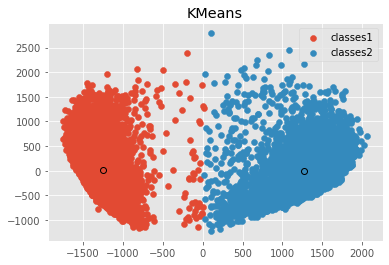

In [30]:
plt.title('KMeans')
plt.scatter(X_norm_r_1[label == 0][:,0], X_norm_r_1[label == 0][:,1], cmap=plt.cm.get_cmap('Spectral', 10))
plt.scatter(X_norm_r_1[label == 1][:,0], X_norm_r_1[label == 1][:,1], cmap=plt.cm.get_cmap('Spectral', 10))
plt.plot(kmeans_center[0][0], kmeans_center[0][1], 'o', markeredgecolor = 'k')
plt.plot(kmeans_center[1][0], kmeans_center[1][1], 'o', markeredgecolor = 'k')
plt.legend((A, B),("classes1", "classes2"))

### 3.2 AutoEncoder
Here a new trainset without normalized should be used. And the training parameters are also showed here.

In [179]:
#Training (optimisation) parameters
batch_size=32
learning_rate=1e-3
max_epochs = 20
#Trainset without normalized
transform_ae = transforms.Compose([transforms.ToTensor()])
trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform = transform)

In [208]:
class change(torch.utils.data.sampler.Sampler):
    def __init__(self, auto_image, data_source):
        self.auto_image = auto_image
        self.data_source = data_source
        
    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(auto_image)])
    
    def __len__(self):
        return len(self.data_source)

auto_image = [True if trainset.targets[i] == first or trainset.targets[i] == second else False for i in range(len(trainset))]
auto_image = torch.tensor(auto_image)
changed = change(auto_image, trainset)  

train_loader = torch.utils.data.DataLoader(trainset, batch_size, sampler = changed, shuffle=False)

#### a) Autoencoder with 5 Conv2d and 5 ConvTranspose2d

In [180]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 8, 2, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, 2, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 2, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 2, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 5)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 5),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 2, stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=2),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

myAE=Autoencoder()

In [182]:
#Choose mean square error loss
criterion = nn.MSELoss() 
#Choose the Adam optimiser
optimizer = torch.optim.Adam(myAE.parameters(), lr=learning_rate, weight_decay=1e-5)
#Specify how the data will be loaded in batches (with random shuffling)

#Storage
outputs = []
epochs = []
losses = []

#Start training
for epoch in range(max_epochs):
    for data in train_loader:
        img, label = data
        optimizer.zero_grad()
        recon = myAE(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()            

    print('Epoch:{}, Loss:{:.5f}'.format(epoch+1, float(loss)))
    epochs.append(epoch+1)
    losses.append(float(loss))
    outputs.append((epoch, img, recon),)

Epoch:1, Loss:0.03737
Epoch:2, Loss:0.02578
Epoch:3, Loss:0.01741
Epoch:4, Loss:0.01303
Epoch:5, Loss:0.01195
Epoch:6, Loss:0.01114
Epoch:7, Loss:0.01039
Epoch:8, Loss:0.00989
Epoch:9, Loss:0.00973
Epoch:10, Loss:0.00953
Epoch:11, Loss:0.00930
Epoch:12, Loss:0.00911
Epoch:13, Loss:0.00890
Epoch:14, Loss:0.00881
Epoch:15, Loss:0.00863
Epoch:16, Loss:0.00855
Epoch:17, Loss:0.00844
Epoch:18, Loss:0.00816
Epoch:19, Loss:0.00802
Epoch:20, Loss:0.00780


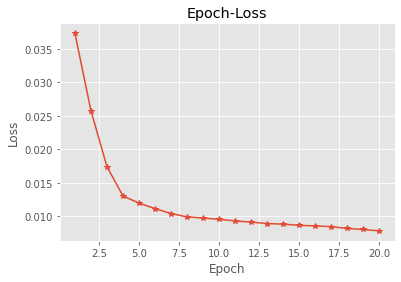

In [183]:
plt.title('Epoch-Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, losses, '*-')

#### b) Autoencode after Modify


In encoder part, we use 5 convolutional layers to get the 3*7*7 images and the use a full-connected layer to get 2 dimensions.

In [184]:
class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 3, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 3, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(3),
            nn.MaxPool2d(2),
            nn.Conv2d(3, 3, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(3),
            nn.MaxPool2d(2),
            nn.Conv2d(3, 3, 3, padding=1),
            nn.BatchNorm2d(3)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(3, 3, 3, stride=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 3, 3, stride=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 3, 3, stride=2),
            nn.LeakyReLU(),
            nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 3, 3, stride=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(3),
            nn.ConvTranspose2d(3, 3, 4, stride=1),  #3*7*7
            nn.Sigmoid()
        )
        self.fc1 = nn.Linear(147,2) #Used to get 2 dimensions
        self.fc2 = nn.Linear(2,147)
              
    def encoder_function(self, x):
        x = self.encoder(x)
        x = x.view(x.shape[0],-1)
        x = self.fc1(x)
        return x
        
    def decoder_function(self, x):
        x = self.fc2(x)
        x = x.view(x.shape[0], 3*7*7)
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

myAE1=Autoencoder1()

In [185]:
#Choose mean square error loss
criterion = nn.MSELoss() 
#Choose the Adam optimiser
optimizer1 = torch.optim.Adam(myAE1.parameters(), lr=learning_rate, weight_decay=1e-5)

#Storage
outputs = []


#Start training
for epoch in range(max_epochs):
    for data in train_loader:
        img, label = data
        optimizer1.zero_grad()
        recon = myAE1(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer1.step()            
    if (epoch % 2) == 0:
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    outputs.append((epoch, img, recon),)

D:\PROGRAM\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 3, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:1, Loss:0.0324
Epoch:3, Loss:0.0216
Epoch:5, Loss:0.0190
Epoch:7, Loss:0.0174
Epoch:9, Loss:0.0161
Epoch:11, Loss:0.0156
Epoch:13, Loss:0.0153
Epoch:15, Loss:0.0151
Epoch:17, Loss:0.0148
Epoch:19, Loss:0.0147


In [202]:
processed_data1 = []
processed_data2 = []
for i,item in enumerate(train_loader):
    img, label = item
    result = myAE1.encoder_function(img)
    processed_data1.append(result[torch.where(label==first)[0],:])
    processed_data2.append(result[torch.where(label==second)[0],:])
data1 = torch.cat(processed_data1,0).squeeze().detach().numpy()
data2 = torch.cat(processed_data2,0).squeeze().detach().numpy()

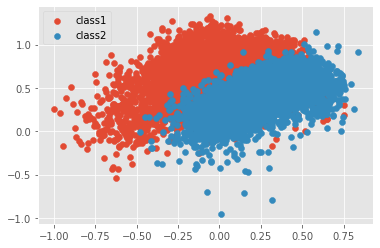

In [203]:
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data2[:,0], data2[:,1])
plt.legend((A, B),("class1", "class2"))

In [204]:
kmeans_data = torch.cat([torch.tensor(data1),torch.tensor(data2)],0)
hasaki = KMeans(n_clusters=2)
print(kmeans_data.shape)
hasaki.fit(kmeans_data)
hasaki_center = hasaki.cluster_centers_
label = hasaki.labels_

torch.Size([12000, 2])


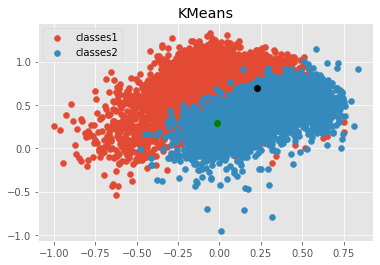

In [207]:
plt.title('KMeans')
plt.scatter(data1[:,0], data1[:,1])
plt.scatter(data2[:,0], data2[:,1])
plt.plot(hasaki_center[0][0], hasaki_center[0][1], 'o', color='g') #Center of class1
plt.plot(hasaki_center[1][0], hasaki_center[1][1], 'o', color='k') #Center of class2
plt.legend((A, B),("classes1", "classes2"))

### 3.3 Observation

1. When we use eigenvectors to reconstruct the images, some images will overlap two types of pictures. If we use StandScalar() to deal with the original images and plot them, the original images will have the same situation as observation.

2. If batch normalized be used in autoencoder, the results of autoencoder will be better than without it. Also, it will be better to use maxpool() to change the size of images rather than use the convolution layer. And the images will be more clear with the number of epoch increased.

3. If we use the trainset with normalized, the results will be worse than we use current trainset. It might because of when we use normalized, some features of the images will lose so that when autoencoder be used, the data points will repeat.